In [1]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier

from itertools import combinations


pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)
print("Libraries ready.")

Libraries ready.


In [2]:
CSV_PATH = "C:/Users/hasan/OneDrive/Desktop/Apziva/1. Happy Customers Project/ACME-HappinessSurvey2020.csv"  
assert os.path.exists(CSV_PATH), f"CSV not found at: {CSV_PATH}"

df = pd.read_csv(CSV_PATH)
display(df.head(10))

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)
print("\nDescribe:\n", df.describe())

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5
5,1,5,5,3,5,5,5
6,0,3,1,2,2,1,3
7,1,5,4,4,4,4,5
8,0,4,1,4,4,4,4
9,0,4,4,4,2,5,5


Shape: (126, 7)
Columns: ['Y', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6']

Dtypes:
 Y     int64
X1    int64
X2    int64
X3    int64
X4    int64
X5    int64
X6    int64
dtype: object

Describe:
                 Y          X1          X2          X3          X4          X5          X6
count  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000
mean     0.547619    4.333333    2.531746    3.309524    3.746032    3.650794    4.253968
std      0.499714    0.800000    1.114892    1.023440    0.875776    1.147641    0.809311
min      0.000000    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000
25%      0.000000    4.000000    2.000000    3.000000    3.000000    3.000000    4.000000
50%      1.000000    5.000000    3.000000    3.000000    4.000000    4.000000    4.000000
75%      1.000000    5.000000    3.000000    4.000000    4.000000    4.000000    5.000000
max      1.000000    5.000000    5.000000    5.000000    5.000000    5.000000    5.000000


In [3]:
missing = df.isna().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing)

if "Y" not in df.columns:
    raise ValueError("Target column 'Y' is missing.")

print("\nTarget distribution (Y):\n", df["Y"].value_counts(dropna=False))

expected_features = [f"X{i}" for i in range(1, 7)]
available_features = [c for c in expected_features if c in df.columns]
if len(available_features) != 6:
    print("WARNING: Some of X1..X6 missing; using:", available_features)
else:
    print("Using features:", available_features)

Missing values per column:
 Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

Target distribution (Y):
 Y
1    69
0    57
Name: count, dtype: int64
Using features: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']


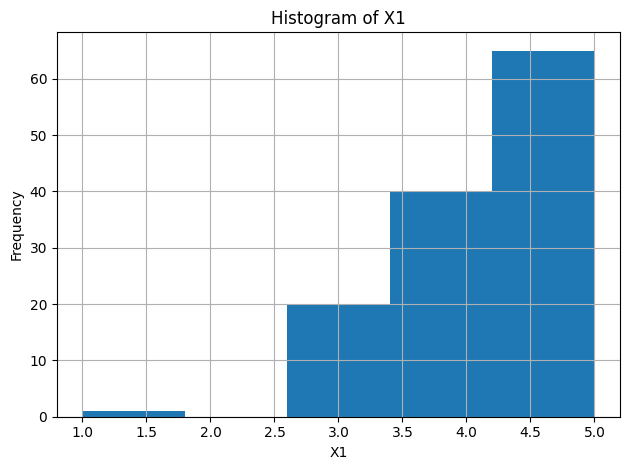

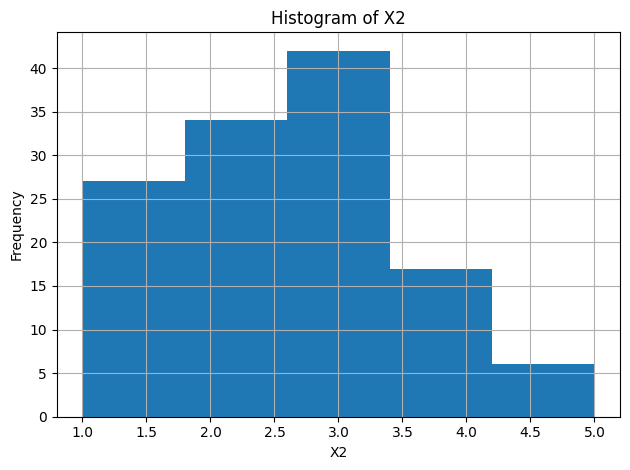

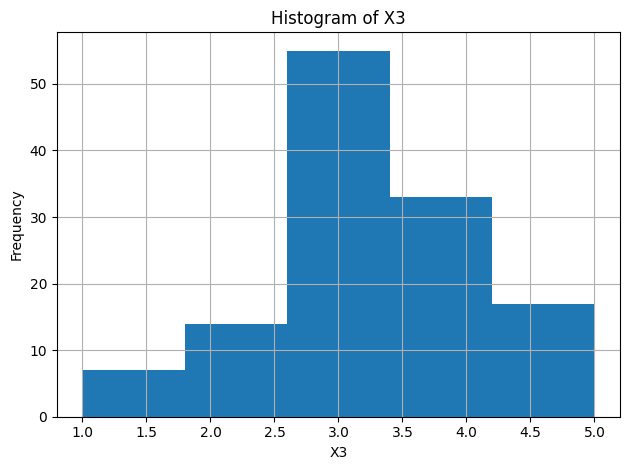

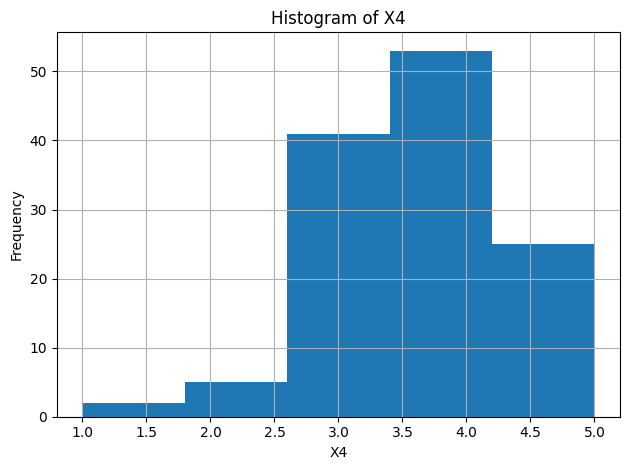

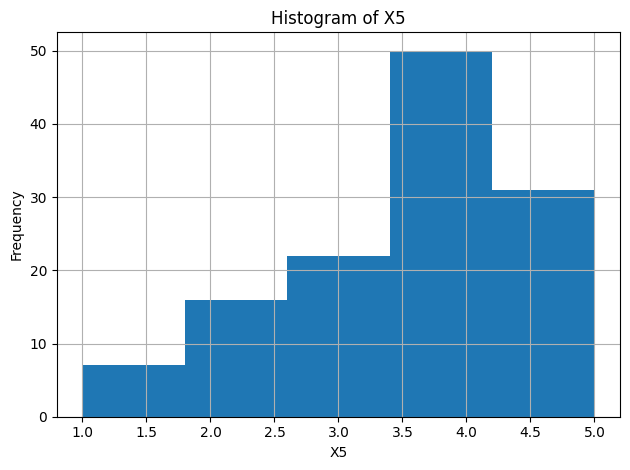

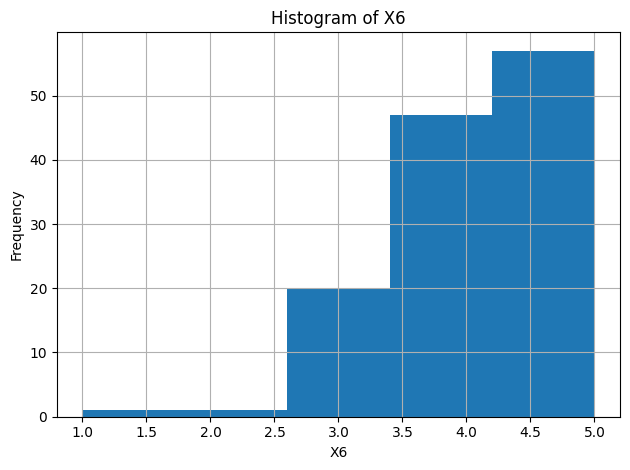

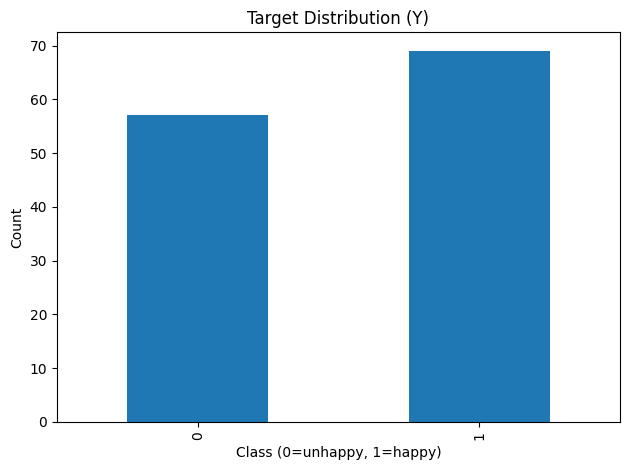

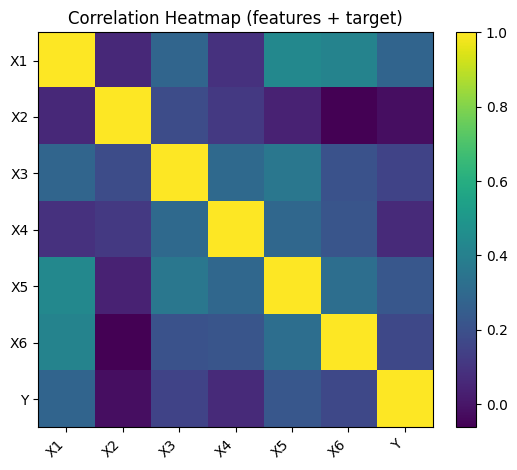

In [4]:
# Histograms
for col in available_features:
    plt.figure()
    df[col].hist(bins=5)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.tight_layout(); plt.show()

# Target bar
plt.figure()
df["Y"].value_counts().sort_index().plot(kind="bar")
plt.title("Target Distribution (Y)")
plt.xlabel("Class (0=unhappy, 1=happy)"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# Correlation heatmap (features + target)
plt.figure()
corr = df[available_features + ["Y"]].corr(numeric_only=True)
im = plt.imshow(corr, interpolation="nearest")
plt.title("Correlation Heatmap (features + target)")
plt.xticks(range(corr.shape[1]), corr.columns, rotation=45, ha="right")
plt.yticks(range(corr.shape[0]), corr.index)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

Train size: (94, 6)   Test size: (32, 6)

=== LogisticRegression ===
Accuracy: 0.7188 | Precision: 0.6957 | Recall: 0.8889 | F1: 0.7805 | ROC-AUC: 0.7817


<Figure size 640x480 with 0 Axes>

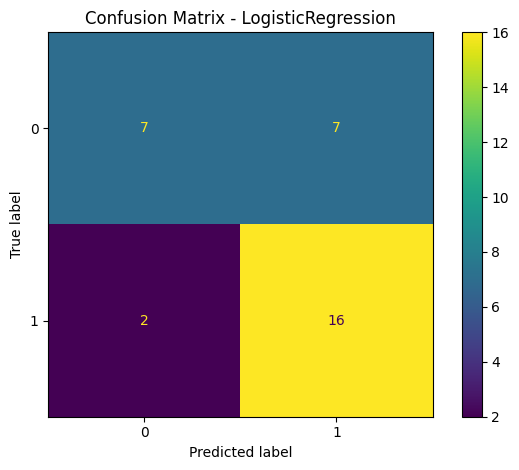


=== RandomForest ===
Accuracy: 0.6562 | Precision: 0.7059 | Recall: 0.6667 | F1: 0.6857 | ROC-AUC: 0.7262


<Figure size 640x480 with 0 Axes>

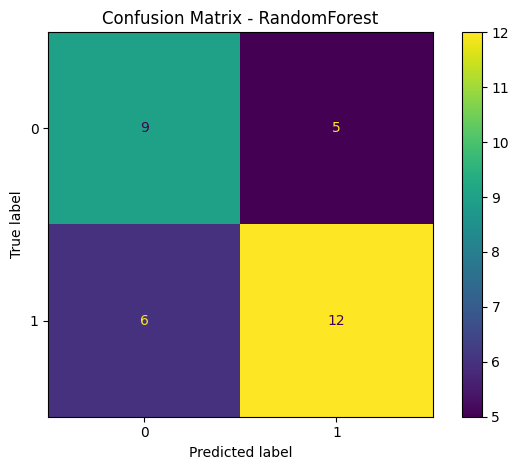

,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.71875,0.695652,0.888889,0.780488,0.781746
1,RandomForest,0.65625,0.705882,0.666667,0.685714,0.726190


In [5]:
X = df[available_features].copy()
y = df["Y"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "  Test size:", X_test.shape)

# --- Cell 6: Baseline Models (LR & RF) ---
models = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=500, solver="lbfgs"))
    ]),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight=None
    )
}

metrics_rows = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except Exception:
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else float("nan")

    metrics_rows.append({
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc
    })

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}", end="")
    if not math.isnan(roc):
        print(f" | ROC-AUC: {roc:.4f}")
    else:
        print()

    # Confusion matrix
    plt.figure()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout(); plt.show()

metrics_df = pd.DataFrame(metrics_rows).sort_values(by="accuracy", ascending=False).reset_index(drop=True)
display(metrics_df)


LogReg standardized coefficients:
   feature   lr_coef
0      X1  0.266978
4      X5  0.247972
1      X2 -0.162577
2      X3  0.077244
5      X6 -0.053889
3      X4  0.012056


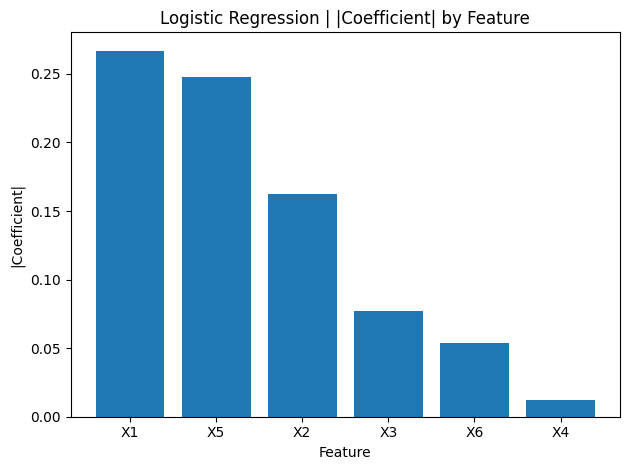


Random Forest feature importances:
   feature  rf_importance
2      X3       0.201967
1      X2       0.188306
4      X5       0.177055
3      X4       0.161492
0      X1       0.153482
5      X6       0.117698


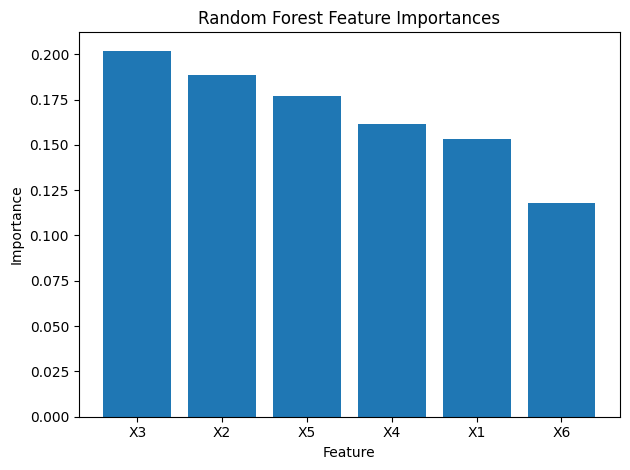

In [6]:
# (a) Logistic Regression coefficients in standardized space
lr_pipe = models["LogisticRegression"]
lr_pipe.fit(X_train, y_train)
lr_coef = lr_pipe.named_steps["clf"].coef_.ravel()
coef_df = pd.DataFrame({"feature": available_features, "lr_coef": lr_coef}) \
          .sort_values("lr_coef", key=lambda s: s.abs(), ascending=False)
print("\nLogReg standardized coefficients:\n", coef_df)
plt.figure(); plt.bar(coef_df["feature"], coef_df["lr_coef"].abs())
plt.title("Logistic Regression | |Coefficient| by Feature")
plt.xlabel("Feature"); plt.ylabel("|Coefficient|")
plt.tight_layout(); plt.show()

# (b) Random Forest feature importances
rf_clf = models["RandomForest"]
rf_clf.fit(X_train, y_train)
rf_imp_df = pd.DataFrame({"feature": available_features,
                          "rf_importance": rf_clf.feature_importances_}) \
            .sort_values("rf_importance", ascending=False)
print("\nRandom Forest feature importances:\n", rf_imp_df)
plt.figure(); plt.bar(rf_imp_df["feature"], rf_imp_df["rf_importance"])
plt.title("Random Forest Feature Importances")
plt.xlabel("Feature"); plt.ylabel("Importance")
plt.tight_layout(); plt.show()


Permutation importance on best model: LogisticRegression


,feature,perm_importance_mean,perm_importance_std
0,X1,0.104688,0.046640
4,X5,0.051562,0.059519
1,X2,0.046875,0.033512
2,X3,0.023438,0.013532
5,X6,0.014063,0.020905
3,X4,0.000000,0.000000


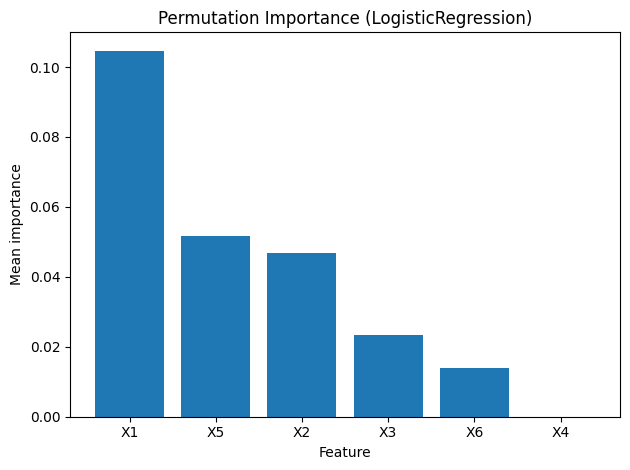

In [7]:
best_model_name = metrics_df.iloc[0]["model"]
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

print(f"\nPermutation importance on best model: {best_model_name}")
perm = permutation_importance(best_model, X_test, y_test, n_repeats=20, random_state=42)
perm_df = pd.DataFrame({
    "feature": available_features,
    "perm_importance_mean": perm.importances_mean,
    "perm_importance_std": perm.importances_std
}).sort_values("perm_importance_mean", ascending=False)
display(perm_df)

plt.figure()
plt.bar(perm_df["feature"], perm_df["perm_importance_mean"])
plt.title(f"Permutation Importance ({best_model_name})")
plt.xlabel("Feature"); plt.ylabel("Mean importance")
plt.tight_layout(); plt.show()

In [8]:
def evaluate_subset(features, model):
    X_tr = X_train[features]
    X_te = X_test[features]
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    return accuracy_score(y_test, y_pred)

selected = []
best_acc = 0.0
progress = []

for _ in range(len(available_features)):
    best_feat = None
    best_score_round = best_acc
    for feat in available_features:
        if feat in selected:
            continue
        trial = selected + [feat]
        score = evaluate_subset(trial, best_model)
        if score > best_score_round:
            best_score_round = score
            best_feat = feat
    if best_feat is not None:
        selected.append(best_feat)
        best_acc = best_score_round
        progress.append({"k_features": len(selected), "feature_added": best_feat, "accuracy": best_acc})
    else:
        break

subset_df = pd.DataFrame(progress)
if not subset_df.empty:
    display(subset_df)
    print("\nOrder by incremental gain:", " -> ".join(subset_df["feature_added"]))
    print(f"Best accuracy with {len(selected)} feature(s): {best_acc:.4f}")
else:
    print("No improvement found via greedy selection.")

,k_features,feature_added,accuracy
0,1,X6,0.71875



Order by incremental gain: X6
Best accuracy with 1 feature(s): 0.7188


In [15]:
# =====================================================
# Customer Happiness — Hyperparameter Tuning + Threshold
# (LogReg, SVC, HistGradientBoosting)
# =====================================================

# --- Cell 1: Setup ---
import os, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# --- Cell 2: Load & split ---
CSV_PATH = "C:/Users/hasan/OneDrive/Desktop/Apziva/1. Happy Customers Project/ACME-HappinessSurvey2020.csv"
assert os.path.exists(CSV_PATH), f"CSV not found at: {CSV_PATH}"

df = pd.read_csv(CSV_PATH)
X = df[[f"X{i}" for i in range(1, 7)]].copy()
y = df["Y"].copy()

# Keep this split fixed for apples-to-apples comparisons
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_train.shape, X_test.shape


((94, 6), (32, 6))

In [16]:
# --- Cell 3: Utility helpers ---
def test_metrics(estimator, name="model"):
    y_pred = estimator.predict(X_test)
    try:
        y_proba = estimator.predict_proba(X_test)[:, 1]
    except Exception:
        y_proba = None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else float("nan")
    return dict(model=name, accuracy=acc, precision=prec, recall=rec, f1=f1, roc_auc=roc)

def plot_cm(y_true, y_pred, title="Confusion Matrix"):
    plt.figure()
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [17]:
# --- Cell 4: Tune Logistic Regression (fast grid) ---
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, solver="lbfgs"))
])
lr_grid = {"clf__C": [0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0]}
lr_cv = GridSearchCV(lr, lr_grid, scoring="accuracy", cv=cv, refit=True)
lr_cv.fit(X_train, y_train)

lr_best = lr_cv.best_estimator_
print("LR best params:", lr_cv.best_params_, "| CV mean acc:", round(lr_cv.best_score_, 4))
test_lr = test_metrics(lr_best, "LogReg (tuned)")
test_lr


LR best params: {'clf__C': 0.1} | CV mean acc: 0.4895


{'model': 'LogReg (tuned)',
 'accuracy': 0.71875,
 'precision': 0.68,
 'recall': 0.9444444444444444,
 'f1': 0.7906976744186047,
 'roc_auc': 0.8015873015873016}

In [18]:
# --- Cell 5: Tune SVC (RBF) ---
svc = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", probability=True, random_state=42))
])
svc_grid = {"svc__C": [0.5, 1, 2, 3, 5], "svc__gamma": ["scale", 0.1, 0.2, 0.3]}
svc_cv = GridSearchCV(svc, svc_grid, scoring="accuracy", cv=cv, refit=True)
svc_cv.fit(X_train, y_train)

svc_best = svc_cv.best_estimator_
print("SVC best params:", svc_cv.best_params_, "| CV mean acc:", round(svc_cv.best_score_, 4))
test_svc = test_metrics(svc_best, "SVC_RBF (tuned)")
test_svc


SVC best params: {'svc__C': 2, 'svc__gamma': 0.2} | CV mean acc: 0.5532


{'model': 'SVC_RBF (tuned)',
 'accuracy': 0.71875,
 'precision': 0.7368421052631579,
 'recall': 0.7777777777777778,
 'f1': 0.7567567567567567,
 'roc_auc': 0.20238095238095238}

In [19]:
# --- Cell 6: Tune HistGradientBoosting (small grid) ---
hgb = HistGradientBoostingClassifier(random_state=42)
hgb_grid = {
    "learning_rate": [0.05, 0.1],
    "max_depth": [None, 5],
    "max_leaf_nodes": [31, 63],
    "min_samples_leaf": [10]
}
hgb_cv = GridSearchCV(hgb, hgb_grid, scoring="accuracy", cv=cv, refit=True)
hgb_cv.fit(X_train, y_train)

hgb_best = hgb_cv.best_estimator_
print("HGB best params:", hgb_cv.best_params_, "| CV mean acc:", round(hgb_cv.best_score_, 4))
test_hgb = test_metrics(hgb_best, "HGB (tuned)")
test_hgb


HGB best params: {'learning_rate': 0.05, 'max_depth': None, 'max_leaf_nodes': 31, 'min_samples_leaf': 10} | CV mean acc: 0.5526


{'model': 'HGB (tuned)',
 'accuracy': 0.71875,
 'precision': 0.7368421052631579,
 'recall': 0.7777777777777778,
 'f1': 0.7567567567567567,
 'roc_auc': 0.7738095238095238}

             model  accuracy  precision    recall        f1   roc_auc
0   LogReg (tuned)   0.71875   0.680000  0.944444  0.790698  0.801587
1  SVC_RBF (tuned)   0.71875   0.736842  0.777778  0.756757  0.202381
2      HGB (tuned)   0.71875   0.736842  0.777778  0.756757  0.773810


<Figure size 640x480 with 0 Axes>

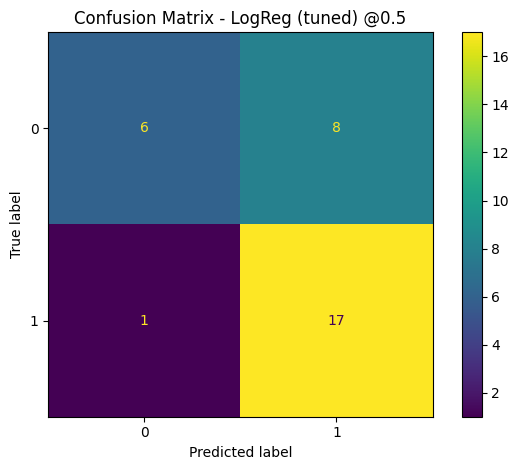

,model,accuracy,precision,recall,f1,roc_auc
0,LogReg (tuned),0.71875,0.680000,0.944444,0.790698,0.801587
1,SVC_RBF (tuned),0.71875,0.736842,0.777778,0.756757,0.202381
2,HGB (tuned),0.71875,0.736842,0.777778,0.756757,0.773810


In [20]:
# --- Cell 7: Compare tuned models & pick the best ---
res_df = pd.DataFrame([test_lr, test_svc, test_hgb]).sort_values(by="accuracy", ascending=False).reset_index(drop=True)
print(res_df)
best_name = res_df.iloc[0]["model"]
best_est  = {"LogReg (tuned)": lr_best, "SVC_RBF (tuned)": svc_best, "HGB (tuned)": hgb_best}[best_name]

# Baseline confusion matrix @ default threshold (0.5 if proba; SVC has it enabled)
try:
    y_proba = best_est.predict_proba(X_test)[:, 1]
    y_pred  = (y_proba >= 0.5).astype(int)
except Exception:
    # Just in case, but SVC has probability=True above
    y_pred = best_est.predict(X_test)

plot_cm(y_test, y_pred, title=f"Confusion Matrix - {best_name} @0.5")
res_df


Chosen threshold from validation: t* = 0.450 | Val acc = 0.5789

Default vs tuned threshold on TEST:
            model  threshold  accuracy  precision    recall        f1   roc_auc
0  LogReg (tuned)       0.50   0.71875    0.68000  0.944444  0.790698  0.801587
1  LogReg (tuned)       0.45   0.65625    0.62963  0.944444  0.755556  0.801587


<Figure size 640x480 with 0 Axes>

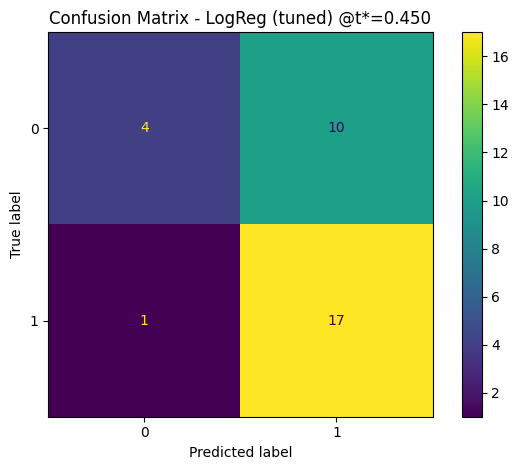

In [21]:
# --- Cell 8: Validation-based threshold optimization on the BEST model ---
# Clean approach: split a validation set from training to pick threshold (no test peeking)
supports_proba = hasattr(best_est, "predict_proba")
if supports_proba:
    X_tr2, X_val, y_tr2, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    best_est.fit(X_tr2, y_tr2)
    val_proba = best_est.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0.20, 0.80, 61)
    val_accs = [accuracy_score(y_val, (val_proba >= t).astype(int)) for t in thresholds]
    t_star = float(thresholds[int(np.argmax(val_accs))])
    print(f"Chosen threshold from validation: t* = {t_star:.3f} | Val acc = {max(val_accs):.4f}")

    # Evaluate tuned threshold on the untouched test set
    best_est.fit(X_train, y_train)
    proba_test = best_est.predict_proba(X_test)[:, 1]
    y_pred_05  = (proba_test >= 0.5).astype(int)
    y_pred_t   = (proba_test >= t_star).astype(int)

    def m(y_true, y_pred, y_proba):
        return dict(
            accuracy = accuracy_score(y_true, y_pred),
            precision= precision_score(y_true, y_pred, zero_division=0),
            recall   = recall_score(y_true, y_pred, zero_division=0),
            f1       = f1_score(y_true, y_pred, zero_division=0),
            roc_auc  = roc_auc_score(y_true, y_proba),
        )

    m_05 = m(y_test, y_pred_05, proba_test)
    m_t  = m(y_test, y_pred_t,  proba_test)

    summary = pd.DataFrame([
        {"model": best_name, "threshold": 0.50, **m_05},
        {"model": best_name, "threshold": t_star, **m_t},
    ])
    print("\nDefault vs tuned threshold on TEST:")
    print(summary.sort_values("accuracy", ascending=False).reset_index(drop=True))

    plot_cm(y_test, y_pred_t, title=f"Confusion Matrix - {best_name} @t*={t_star:.3f}")
else:
    print(f"{best_name} does not support predict_proba; skipping threshold tuning.")


In [23]:
# ============================
# Section A — Expanded Tuning
# ============================
#import os, math, numpy as np, pandas as pd
#from itertools import combinations
#from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
#from sklearn.preprocessing import StandardScaler
#from sklearn.pipeline import Pipeline
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
#from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC
#from sklearn.ensemble import HistGradientBoostingClassifier

# --- Load
CSV_PATH = "ACME-HappinessSurvey2020.csv"
assert os.path.exists(CSV_PATH), f"CSV not found at: {CSV_PATH}"
df = pd.read_csv(CSV_PATH)
X_all = df[[f"X{i}" for i in range(1, 7)]].copy()
y = df["Y"].copy()

# Fixed split (same as before)
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_all, y, test_size=0.25, random_state=42, stratify=y
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Based on earlier importances: X1, X5, X2, X3 (X6 small, X4 near-zero for LR)
ranked = ["X1", "X5", "X2", "X3", "X6", "X4"]
subset_candidates = [
    ["X1","X5"],
    ["X1","X5","X2"],
    ["X1","X5","X2","X3"],
    ranked[:5],      # top-5
    ranked[:6],      # all
]

def score_model(model, grid, X_train, y_train):
    gs = GridSearchCV(model, grid, scoring="accuracy", cv=cv, refit=True)
    gs.fit(X_train, y_train)
    return gs.best_estimator_, gs.best_score_, gs.best_params_

def eval_test(est, X_test, y_test, name):
    y_pred = est.predict(X_test)
    try:
        y_proba = est.predict_proba(X_test)[:,1]
        roc = roc_auc_score(y_test, y_proba)
    except Exception:
        roc = float("nan")
    return dict(
        model=name,
        accuracy=accuracy_score(y_test, y_pred),
        precision=precision_score(y_test, y_pred, zero_division=0),
        recall=recall_score(y_test, y_pred, zero_division=0),
        f1=f1_score(y_test, y_pred, zero_division=0),
        roc_auc=roc
    )

results = []
best_bundle = None  # (model_name, subset, best_estimator)

for subset in subset_candidates:
    X_train = X_train_full[subset]
    X_test  = X_test_full[subset]

    # 1) SVC (RBF) — slightly wider, still fast
    svc = Pipeline([("scaler", StandardScaler()), ("svc", SVC(kernel="rbf", probability=True, random_state=42))])
    svc_grid = {"svc__C": [0.5, 1, 2, 3, 5, 8, 12], "svc__gamma": ["scale", 0.05, 0.1, 0.2, 0.3]}
    svc_best, svc_cv_acc, svc_params = score_model(svc, svc_grid, X_train, y_train)
    svc_test = eval_test(svc_best, X_test, y_test, f"SVC_RBF | {subset}")
    svc_test["cv_mean_accuracy"] = svc_cv_acc
    svc_test["best_params"] = svc_params
    results.append(svc_test)

    # 2) Logistic Regression (try with/without class_weight)
    for cw in [None, "balanced"]:
        lr = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=5000, solver="lbfgs", class_weight=cw))])
        lr_grid = {"clf__C": [0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0]}
        lr_best, lr_cv_acc, lr_params = score_model(lr, lr_grid, X_train, y_train)
        lr_test = eval_test(lr_best, X_test, y_test, f"LogReg(cw={cw}) | {subset}")
        lr_test["cv_mean_accuracy"] = lr_cv_acc
        lr_test["best_params"] = lr_params
        results.append(lr_test)

    # 3) HistGradientBoosting (small grid incl. mild L2)
    hgb = HistGradientBoostingClassifier(random_state=42)
    hgb_grid = {
        "learning_rate": [0.05, 0.1],
        "max_depth": [None, 5],
        "max_leaf_nodes": [31, 63],
        "min_samples_leaf": [10, 15],
        "l2_regularization": [0.0, 0.1, 0.5]
    }
    hgb_best, hgb_cv_acc, hgb_params = score_model(hgb, hgb_grid, X_train, y_train)
    hgb_test = eval_test(hgb_best, X_test, y_test, f"HGB | {subset}")
    hgb_test["cv_mean_accuracy"] = hgb_cv_acc
    hgb_test["best_params"] = hgb_params
    results.append(hgb_test)

res_df = pd.DataFrame(results).sort_values(by="accuracy", ascending=False).reset_index(drop=True)
print("\nTop candidates by TEST accuracy:")
print(res_df.head(10))

best_row = res_df.iloc[0]
print("\nBest so far:")
print(best_row)



Top candidates by TEST accuracy:
                                               model  accuracy  precision    recall        f1   roc_auc  cv_mean_accuracy  \
0                                 HGB | ['X1', 'X5']   0.78125   0.761905  0.888889  0.820513  0.811508          0.596491   
1                             SVC_RBF | ['X1', 'X5']   0.75000   0.708333  0.944444  0.809524  0.851190          0.564327   
2                       SVC_RBF | ['X1', 'X5', 'X2']   0.75000   0.750000  0.833333  0.789474  0.791667          0.648538   
3                           HGB | ['X1', 'X5', 'X2']   0.75000   0.750000  0.833333  0.789474  0.763889          0.585965   
4                 SVC_RBF | ['X1', 'X5', 'X2', 'X3']   0.75000   0.750000  0.833333  0.789474  0.775794          0.552632   
5           SVC_RBF | ['X1', 'X5', 'X2', 'X3', 'X6']   0.71875   0.714286  0.833333  0.769231  0.821429          0.563158   
6  LogReg(cw=balanced) | ['X1', 'X5', 'X2', 'X3',...   0.71875   0.695652  0.888889  0.7804